In [1]:
import glob
import os
import librosa
from librosa import display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
features = np.loadtxt('nn_simple_features.csv', delimiter=',')
labels = np.array(np.loadtxt('nn_simple_labels.csv', delimiter=','), dtype=np.int)

In [3]:
from sklearn.preprocessing import normalize

X_all = features
y_all = labels

In [44]:
from sklearn.model_selection import train_test_split
import time

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, stratify=y_all, train_size=.85, random_state=round(time.time()))

# X_train, X_val, y_train, y_val = train_test_split(
#     X_not_test, y_not_rest, stratify=y_not_rest, train_size=.9, random_state=round(time.time()))

print(X_train.shape)
print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(10052, 1280)
(10052, 5)
(1774, 1280)
(1774, 5)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [45]:
# Parameters
learning_rate = 0.001

# global_step = tf.Variable(0, trainable=False)
# starter_learning_rate = 0.00
# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            50, 0.99, staircase=True)

epochs = 60
batch_size = 100

# Network Parameters
n_input = 40 * 32
n_classes = 5
dropout = .7 # Dropout, probability to keep units

# 1. Define Variables and Placeholders
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

def build_model(x, dropout, activation):
    
    x = tf.reshape(x, shape=[-1, 40, 32, 1])
    
    conv1 = tf.layers.conv2d(x, 4, 5, activation=activation)
    conv1 = tf.layers.batch_normalization(conv1)
    conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
    conv1 = tf.nn.dropout(conv1, dropout)
    
    conv2 = tf.layers.conv2d(conv1, 8, 3, activation=activation)
    conv2 = tf.layers.batch_normalization(conv2)
    conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
    conv2 = tf.nn.dropout(conv2, dropout)
    
    fc1 = tf.contrib.layers.flatten(conv2)

    fc1 = tf.layers.dense(fc1, 128, activation=activation)
    fc1 = tf.layers.batch_normalization(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    fc2 = tf.layers.dense(fc1, 64, activation=activation)
    fc2 = tf.layers.batch_normalization(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    out = tf.layers.dense(fc2, n_classes)

    return out

predictions = build_model(x, keep_prob, activation=tf.nn.relu)
# 3. Define the loss function  
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
# 4. Define the accuracy 
correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 5. Define an optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost, global_step=global_step)

# Initializing the variables
init = tf.global_variables_initializer()

In [46]:
train_accuracy = []
train_cost = []
val_accuracy = []
val_cost = []

def feed_next_batch(train_size, batch_size=64):
    
    start = 0
    while start < train_size:
        yield start, start + batch_size
        start += batch_size

with tf.Session() as sess:
    sess.run(init)
    # Keep training until reach max iterations
    for epoch in range(epochs):
        
        indices = np.arange(len(y_train))
        np.random.shuffle(indices)
        X_train, y_train =  X_train[indices], y_train[indices]
        
        for start, end in feed_next_batch(len(X_train), batch_size=batch_size):
            # Run optimization op (backprop)
            batch_x, batch_y = X_train[start:end], y_train[start:end]
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            
        # Calculate batch loss and accuracy
        train_loss, train_acc = sess.run([cost, accuracy], feed_dict={x: X_train, 
                                                                      y: y_train,
                                                                      keep_prob: 1.0})
        
        print('Epoch %d' % (epoch + 1))
        if type(learning_rate) is not float:
            print('learning_rate:', sess.run(learning_rate))

        train_cost.append(train_loss)
        train_accuracy.append(train_acc)
        print ("Training loss:", train_loss, ', Training acc: ', train_acc)

        val_loss, val_acc = sess.run([cost, accuracy], feed_dict={x: X_test, 
                                                                    y: y_test,
                                                                   keep_prob: 1.0})
        val_cost.append(val_loss)
        val_accuracy.append(val_acc)
        print ("Test loss:", val_loss, ', Test acc: ', val_acc)
        print('-' * 80)
            
    print ("Optimization Finished!")

    # Calculate accuracy for all test samples
    print ("Training Accuracy:", \
        sess.run(accuracy, feed_dict={x: X_train,
                                      y: y_train,
                                     keep_prob: 1.0}))
    print ("Test Accuracy:", \
        sess.run(accuracy, feed_dict={x: X_test,
                                      y: y_test,
                                     keep_prob: 1.0}))

Epoch 1
Training loss: 1.60041 , Training acc:  0.226025
Test loss: 1.6045 , Test acc:  0.226043
--------------------------------------------------------------------------------
Epoch 2
Training loss: 1.60235 , Training acc:  0.226025
Test loss: 1.60428 , Test acc:  0.215896
--------------------------------------------------------------------------------
Epoch 3
Training loss: 1.6033 , Training acc:  0.237664
Test loss: 1.60474 , Test acc:  0.235626
--------------------------------------------------------------------------------
Epoch 4
Training loss: 1.60276 , Training acc:  0.251393
Test loss: 1.60425 , Test acc:  0.245209
--------------------------------------------------------------------------------
Epoch 5
Training loss: 1.59837 , Training acc:  0.253283
Test loss: 1.60151 , Test acc:  0.232244
--------------------------------------------------------------------------------
Epoch 6
Training loss: 1.58455 , Training acc:  0.289296
Test loss: 1.5886 , Test acc:  0.277339
----------

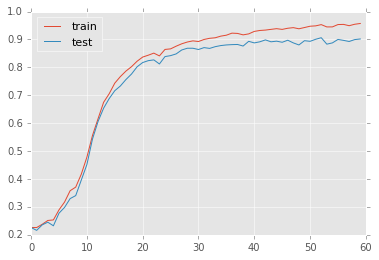

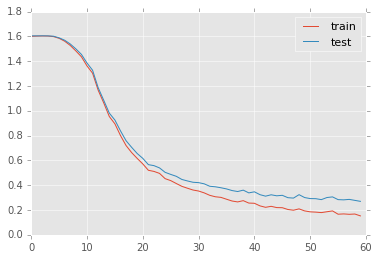

In [47]:
def plot_accuracy_and_cost():
    
    # accuracy training vs testing dataset
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.grid(True)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    # loss training vs testing dataset
    plt.plot(train_cost)
    plt.plot(val_cost)
    plt.grid(True)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

plot_accuracy_and_cost()